# Laboratorio 9 Ataque y defensa de modelos de Deep Learning
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285

Oscar Esteba Donis - 21610

In [1]:
!pip3 install keras
!pip3 install tensorflow

### Obteniendo Librerias

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.extraction import CopycatCNN
from art.defences.postprocessor import ReverseSigmoid

# Parte 1

In [3]:
!pip3 install adversarial-robustness-toolbox

#### Obtención de la data

In [4]:
path = './malimg_paper_dataset_imgs/'

In [5]:
# Obtenemos la lista de familias de malware
malware_families = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Contamos el número de muestras por familia
family_counts = {}
for family in malware_families:
    family_path = os.path.join(path, family)
    count = len([f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))])
    family_counts[family] = count

# creamos un DataFrame para visualizar los datos
df_counts = pd.DataFrame(list(family_counts.items()), columns=['Family', 'Count'])
df_counts = df_counts.sort_values(by='Count', ascending=False)


#### Creamos la normalización de los datos, y estructuramos nuestros datos para el modelo

In [6]:
# Normalizamos las datos
def normalize_image(image):
    # Normalizamos la imagen a un rango de 0 a 1
    return image / 255.0

# división de los datos en conjuntos de entrenamiento y prueba 70% entrenamiento y un 30% de pruebas
def load_data(path, test_size=0.3, random_state=42):
    images = []
    labels = []
    
    for family in malware_families:
        family_path = os.path.join(path, family)
        files = [f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))]
        
        for file in files:
            img_path = os.path.join(family_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Redimensionamos la imagen
            img = normalize_image(img)  # Normalizamos la imagen
            
            images.append(img)
            labels.append(family)
    
    images = np.array(images)
    labels = np.array(labels)

    images = images.reshape(-1, 64, 64, 1)

    # One-hot encode the labels
    label_encoder = LabelBinarizer()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test, label_encoder


#### Obtenemos los datos de entrenamiento y prueba

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test, label_encoder = load_data(path)



#### Cargamos el modelo a atacar

In [8]:
# Cargamos el modelo entrenado creado en el laboratorio anterior
vulnerable_model = tf.keras.models.load_model("malware_model.h5")
vulnerable_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,803 (6.21 MB)

 Trainable params: 1,627,801 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

#### Creamos el classificador con la librería ART para atacar

In [9]:
# Creamos la función de pérdida
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Creamos el clasificador ART a partir del modelo vulnerable
classifier = TensorFlowV2Classifier(
    model=vulnerable_model,
    nb_classes=len(malware_families),
    loss_object=loss_object,
    input_shape=(64, 64, 1),
    clip_values=(0, 1)
)

## Ataque 1

In [10]:

# Generamos el objeto de Fast Gradient Method
attack_evasion_fgsm = FastGradientMethod(estimator=classifier, eps=0.15)
# Generamos ejemplos adversariales
X_test_attack_1 = attack_evasion_fgsm.generate(x=X_test)

# Evaluamos el modelo con los ejemplos adversariales
accuracy_attack_1 = np.mean(np.argmax(classifier.predict(X_test_attack_1), axis=1) == np.argmax(y_test, axis=1))
# Mostramos la precisión del modelo con los ejemplos adversariales
print(f"Precisión del modelo con ejemplos adversariales creados: {accuracy_attack_1}")

Precisión del modelo con ejemplos adversariales creados: 0.1206281227694504


## Ataque 2

In [11]:
X_train_stolen = X_train[5000:]
Y_train_stolen = y_train[5000:]

In [12]:
copycat_cnn = CopycatCNN(
    batch_size_fit=128,
    batch_size_query=128,
    nb_epochs=10,
    nb_stolen=20000,
    classifier=classifier
    )

In [13]:
#Definimos un nuevo modelo
def create_blank_model():
    # Definimos la arquitectura del modelo
    model = tf.keras.models.Sequential([
        Conv2D(filters=16, kernel_size=2, activation="relu", input_shape=(64, 64, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(filters=128, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(filters=32, kernel_size=2, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=(len(malware_families)), activation="softplus")
    ])

    # Compilamos el modelo
    model.compile(
        optimizer="rmsprop",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Retornamos el model
    return model

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

# Creamos el modelo de extracción
model_stolen = TensorFlowV2Classifier(
    model=create_blank_model(),
    nb_classes=len(malware_families),
    input_shape=(64, 64, 1),
    optimizer=optimizer,
    loss_object=loss,
    train_step=None,  
    clip_values=(0.0, 1.0)
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Entrenamos el modelo de extracción con los datos robados y con el modelo vulnerable
stolen_classifier = copycat_cnn.extract(
    x=X_train_stolen,
    thieved_classifier=model_stolen
)

2025-05-12 09:44:37.621699: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-12 09:44:38.163601: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-12 09:44:39.054603: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-12 09:44:40.908657: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# Evaluamos al modelo original con los datos de prueba
score_original = classifier._model.evaluate(
    x=X_test, 
    y=y_test
)

# Evaluamos al modelo robado con los datos de prueba
score_stolen = stolen_classifier._model.evaluate(
    x=X_test, 
    y=y_test
)

# Comnparamos las precisiones y perdidas de ambos modelos con los datos de prueba
print(f"Precisión modelo original: {score_original[1]:.2f} vs Precisión modelo robado: {score_stolen[1]:.2f}")
print(f"Pérdido modelo original: {score_original[0]:.2f} vs Pérdida modelo robado: {score_stolen[0]:.2f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9679 - loss: 0.1205
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4472 - loss: 1.9514
Precisión modelo original: 0.96 vs Precisión modelo robado: 0.45
Pérdido modelo original: 0.13 vs Pérdida modelo robado: 1.98


# Parte 2

## Defensa 1

In [17]:
# Creamos función para aleatorizar la entrada
def input_randomization(x, noise_level=0.1):
    return x + np.random.normal(0, noise_level, size=x.shape)

# Creamos la función de defensa para obtener las predicciones con defensa
def predict_with_defense(model, x, num_samples=10):
    predictions = []
    for _ in range(num_samples):
        x_randomized = input_randomization(x)
        predictions.append(model.predict(x_randomized))
    return np.mean(predictions, axis=0)

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Precisión del modelo original con ejemplos limpios: 0.9621698786581013
Precisión del modelo original con ejemplos adversariales: 0.1206281227694504
Precisión del modelo con defensa contra ejemplos adversariales: 0.13882940756602427
Mejora en robustez: 0.0182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━

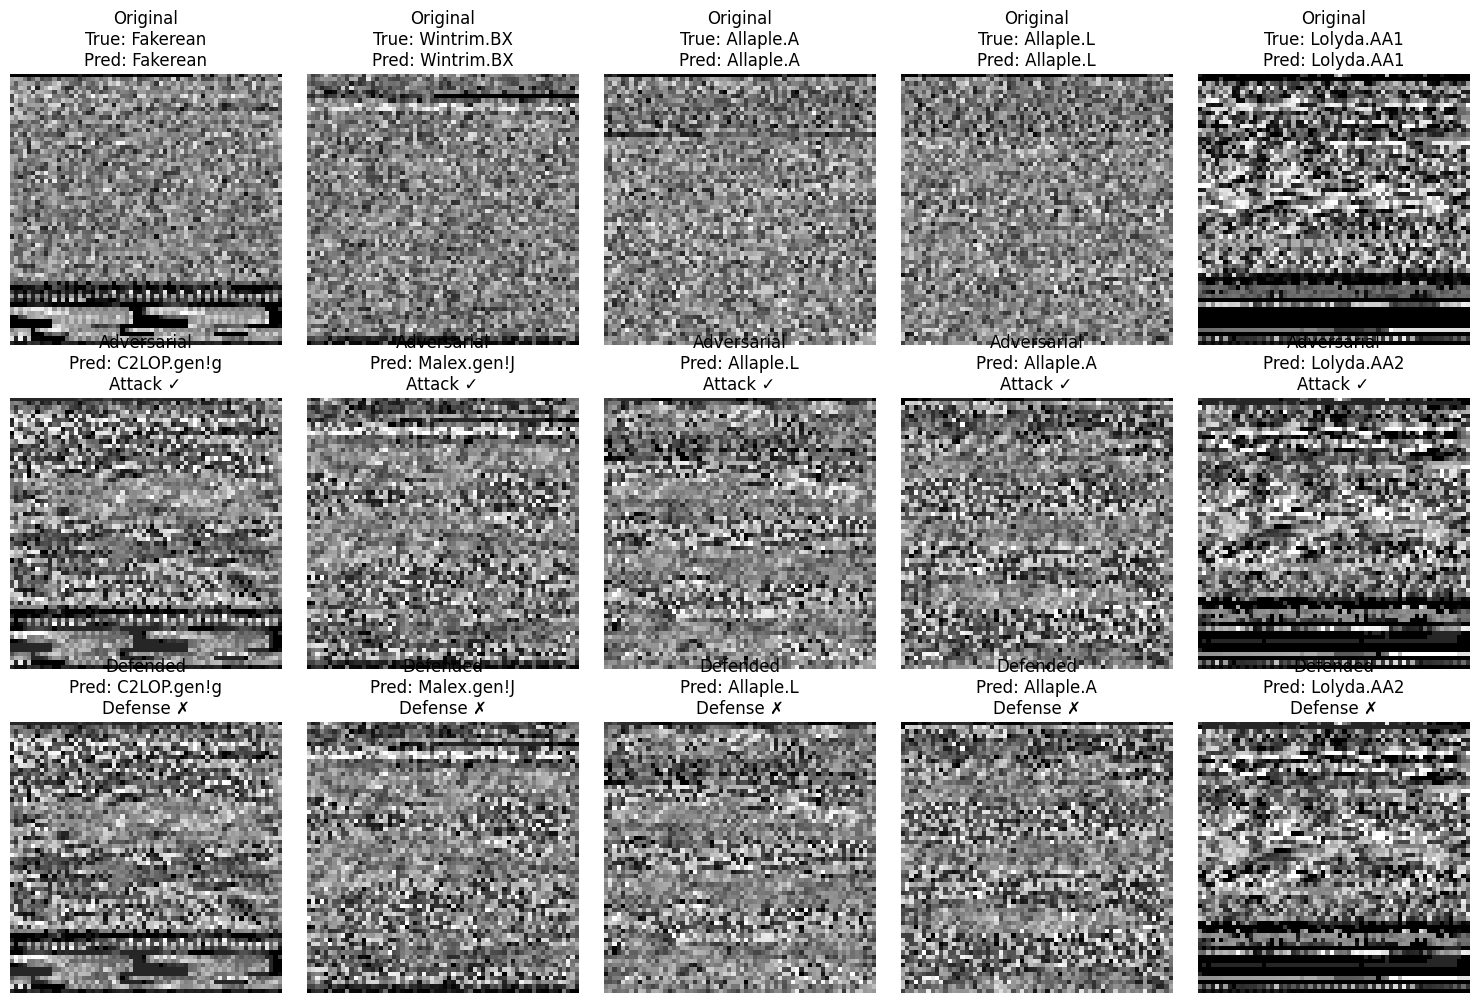

In [18]:
# Creamos una clase para crear un modelo clasificador con defensa
class RandomizedDefenseClassifier:
    def __init__(self, model, noise_level=0.1, num_samples=10):
        self.model = model
        self.noise_level = noise_level
        self.num_samples = num_samples
    
    def predict(self, x):
        return predict_with_defense(self.model, x, self.num_samples)

# Creamos el clasificador con defensa para ataque 1
defended_classifier = RandomizedDefenseClassifier(
    model=vulnerable_model,
    noise_level=0.1, 
    num_samples=10
)

# Evaluamos el modelo defendido con los ejemplos adversariales
defended_predictions = defended_classifier.predict(X_test_attack_1)

# Calculamos la precisión del modelo defendido
accuracy_defended = np.mean(np.argmax(defended_predictions, axis=1) == np.argmax(y_test, axis=1))

# Creamos una comparación de la precisión del modelo original con ejemplos limpios y adversariales
print(f"Precisión del modelo original con ejemplos limpios: {np.mean(np.argmax(classifier.predict(X_test), axis=1) == np.argmax(y_test, axis=1))}")
print(f"Precisión del modelo original con ejemplos adversariales: {accuracy_attack_1}")
print(f"Precisión del modelo con defensa contra ejemplos adversariales: {accuracy_defended}")
print(f"Mejora en robustez: {accuracy_defended - accuracy_attack_1:.4f}")

# Mostramos una visualización de las imágenes originales, adversariales y defendidas
plt.figure(figsize=(15, 10))
for i in range(5):
    # Seleccionamos un índice aleatorio
    idx = np.random.randint(0, len(X_test))
    
    # Obtenemos las predicciones hechas por cada modelo
    orig_pred = np.argmax(classifier.predict(X_test[idx:idx+1]), axis=1)[0]
    adv_pred = np.argmax(classifier.predict(X_test_attack_1[idx:idx+1]), axis=1)[0]
    def_pred = np.argmax(defended_classifier.predict(X_test_attack_1[idx:idx+1]), axis=1)[0]
    true_label = np.argmax(y_test[idx])
    
    # Obtenemos las etiquetas de las predicciones
    orig_family = list(label_encoder.classes_)[orig_pred]
    adv_family = list(label_encoder.classes_)[adv_pred]
    def_family = list(label_encoder.classes_)[def_pred]
    true_family = list(label_encoder.classes_)[true_label]
    
    # Mostramos la imagen original
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Original\nTrue: {true_family}\nPred: {orig_family}")
    plt.axis('off')
    
    # Mostramos la imagen adversarial sin defensa
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test_attack_1[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Adversarial\nPred: {adv_family}\nAttack {'✓' if adv_pred != true_label else '✗'}")
    plt.axis('off')
    
    # Mostramos la imagen adversarial con defensa
    plt.subplot(3, 5, i+11)
    plt.imshow(X_test_attack_1[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Defended\nPred: {def_family}\nDefense {'✓' if def_pred == true_label else '✗'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Defensa 2

In [19]:
# Creamos una instancia de un postprocesador de defensa utilizando la técnica Reverse Sigmoid
reverse_sigmoid = ReverseSigmoid(beta=1.5,apply_fit=False, apply_predict=True)

# Creamos una instancia de un clasificador protegido para el ataque 2
classifier.postprocessing_defences = [reverse_sigmoid]

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

# Creamos el modelo de extracción
model_stolen_with_defense = TensorFlowV2Classifier(
    model=create_blank_model(),
    nb_classes=len(malware_families),
    input_shape=(64, 64, 1),
    optimizer=optimizer,
    loss_object=loss,
    train_step=None,  
    clip_values=(0.0, 1.0)
)

In [21]:
# Entrenamos el modelo de extracción utilizando nuestro clasificador protegido
copycat_cnn_protected = CopycatCNN(
    batch_size_fit=128,
    batch_size_query=128,
    nb_epochs=10,
    nb_stolen=20000,
    classifier=classifier
)

In [22]:
# Intentamos robar el modelo protegido
classifier_stolen_protected = copycat_cnn_protected.extract(
    x=X_train_stolen,  
    thieved_classifier=model_stolen_with_defense
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/art/defences/postprocessor/reverse_sigmoid.py:77: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)
2025-05-12 09:44:56.599074: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Testing the performance of the original classifier
score_original = classifier._model.evaluate(
    x=X_test, 
    y=y_test
)

# Testing the performance of the stolen classifier
score_stolen = classifier_stolen_protected._model.evaluate(
    x=X_test, 
    y=y_test
)

# Comparamos las precisiones y perdidas de ambos modelos con los datos de prueba
print(f"Precisión modelo original: {score_original[1]:.2f} vs Precisión modelo robado: {score_stolen[1]:.2f}")
print(f"Pérdida modelo original: {score_original[0]:.2f} vs Pérdida modelo robado: {score_stolen[0]:.2f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9679 - loss: 0.1205
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3164 - loss: 2.8524
Precisión modelo original: 0.96 vs Precisión modelo robado: 0.33
Pérdida modelo original: 0.13 vs Pérdida modelo robado: 2.84
